In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from matplotlib import pyplot as plt
import seaborn as sns
import gzip

test_file = 'avazu-ctr-prediction/test.gz'
samplesubmision_file = 'avazu-ctr-prediction/sampleSubmission.gz'

In [2]:
chunksize = 10 ** 6
num_of_chunk = 0
train = pd.DataFrame()
    
for chunk in pd.read_csv('avazu-ctr-prediction/train.gz', chunksize=chunksize):
    num_of_chunk += 1
    train = pd.concat([train, chunk.sample(frac=.05, replace=False, random_state=123)], axis=0)
    print('Processing Chunk No. ' + str(num_of_chunk))     
    
train.reset_index(inplace=True)

# 備份train 資料長度，以便稍後df重新分割索引用途
train_len = len(train)
train_len

Processing Chunk No. 1
Processing Chunk No. 2
Processing Chunk No. 3
Processing Chunk No. 4
Processing Chunk No. 5
Processing Chunk No. 6
Processing Chunk No. 7
Processing Chunk No. 8
Processing Chunk No. 9
Processing Chunk No. 10
Processing Chunk No. 11
Processing Chunk No. 12
Processing Chunk No. 13
Processing Chunk No. 14
Processing Chunk No. 15
Processing Chunk No. 16
Processing Chunk No. 17
Processing Chunk No. 18
Processing Chunk No. 19
Processing Chunk No. 20
Processing Chunk No. 21
Processing Chunk No. 22
Processing Chunk No. 23
Processing Chunk No. 24
Processing Chunk No. 25
Processing Chunk No. 26
Processing Chunk No. 27
Processing Chunk No. 28
Processing Chunk No. 29
Processing Chunk No. 30
Processing Chunk No. 31
Processing Chunk No. 32
Processing Chunk No. 33
Processing Chunk No. 34
Processing Chunk No. 35
Processing Chunk No. 36
Processing Chunk No. 37
Processing Chunk No. 38
Processing Chunk No. 39
Processing Chunk No. 40
Processing Chunk No. 41


2021448

In [3]:
df = pd.concat([train, pd.read_csv(test_file, compression='gzip')]).drop(['index', 'id'], axis=1)

In [4]:
def get_date(hour):
    y = '20'+str(hour)[:2]
    m = str(hour)[2:4]
    d = str(hour)[4:6]
    return y+'-'+m+'-'+d

df['weekday'] = pd.to_datetime(df.hour.apply(get_date)).dt.dayofweek.astype(str)

def tran_hour(x):
    x = x % 100
    while x in [23,0]:
        return '23-01'
    while x in [1,2]:
        return '01-03'
    while x in [3,4]:
        return '03-05'
    while x in [5,6]:
        return '05-07'
    while x in [7,8]:
        return '07-09'
    while x in [9,10]:
        return '09-11'
    while x in [11,12]:
        return '11-13'
    while x in [13,14]:
        return '13-15'
    while x in [15,16]:
        return '15-17'
    while x in [17,18]:
        return '17-19'
    while x in [19,20]:
        return '19-21'
    while x in [21,22]:
        return '21-23'

# 將hour轉換為時段
df['hour'] = df.hour.apply(tran_hour)

In [5]:
# 確認資料型別
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6598912 entries, 0 to 4577463
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   click             float64
 1   hour              object 
 2   C1                int64  
 3   banner_pos        int64  
 4   site_id           object 
 5   site_domain       object 
 6   site_category     object 
 7   app_id            object 
 8   app_domain        object 
 9   app_category      object 
 10  device_id         object 
 11  device_ip         object 
 12  device_model      object 
 13  device_type       int64  
 14  device_conn_type  int64  
 15  C14               int64  
 16  C15               int64  
 17  C16               int64  
 18  C17               int64  
 19  C18               int64  
 20  C19               int64  
 21  C20               int64  
 22  C21               int64  
 23  weekday           object 
dtypes: float64(1), int64(12), object(11)
memory usage: 1.2+ GB


In [6]:
len_of_feature_count = []
for i in df.columns[2:23].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    len_of_feature_count.append(len(df[i].astype(str).value_counts()))

C1 : 7
banner_pos : 7
site_id : 3496
site_domain : 4333
site_category : 24
app_id : 5466
app_domain : 319
app_category : 31
device_id : 552856
device_ip : 1875405
device_model : 6321
device_type : 5
device_conn_type : 4
C14 : 2662
C15 : 8
C16 : 9
C17 : 470
C18 : 4
C19 : 68
C20 : 169
C21 : 62


In [7]:
need_tran_feature = df.columns[2:4].tolist() + df.columns[13:23].tolist()

for i in need_tran_feature:
    df[i] = df[i].astype(str)

In [8]:
obj_features = []

for i in range(len(len_of_feature_count)):
    if len_of_feature_count[i] > 10:
        obj_features.append(df.columns[2:23].tolist()[i])
obj_features

['site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'C14',
 'C17',
 'C19',
 'C20',
 'C21']

In [9]:
df_describe = df.describe()
df_describe

,click
count,2.021448e+06
mean,1.700731e-01
std,3.756971e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


In [18]:
from tqdm.notebook import tqdm

In [20]:
def obj_clean(X):

    def get_click_rate(x):
        temp = train[train[X.columns[0]] == x]
        res = round((temp.click.sum() / temp.click.count()),3)
        return res

    def get_type(V, str):
        very_high = df_describe.loc['mean','click'] + 0.04
        higher = df_describe.loc['mean','click'] + 0.02
        lower = df_describe.loc['mean','click'] - 0.02
        very_low = df_describe.loc['mean','click'] - 0.04

        vh_type = V[V[str] > very_high].index.tolist()
        hr_type = V[(V[str] > higher) & (V[str] < very_high)].index.tolist()
        vl_type = V[V[str] < very_low].index.tolist()
        lr_type = V[(V[str] < lower) & (V[str] > very_low)].index.tolist()

        return vh_type, hr_type, vl_type, lr_type

    def clean_function(x):
        while x in type_[0]:
            return 'very_high'
        while x in type_[1]:
            return 'higher'
        while x in type_[2]:
            return 'very_low'
        while x in type_[3]:
            return 'lower'
        return 'mid'
        
    print('Run: ', X.columns[0])
    fq = X[X.columns[0]].value_counts()

    if len(fq) > 1000:
        fq = fq[:1000]

    fq = pd.DataFrame(fq)
    fq['new_column'] = fq.index    

    fq['click_rate'] = fq.new_column.apply(get_click_rate)

    type_ = get_type(fq, 'click_rate')
    # print('+')
    # 叫用 clean_funtion funtion，回傳轉換後的特徵向量
    return X[X.columns[0]].apply(clean_function)

for i in tqdm(obj_features, total=len(obj_features)):
    value = obj_clean(df[[i]]).astype(str)
    df[i] = value

df

  0%|          | 0/14 [00:00<?, ?it/s]

Run:  site_id
Run:  site_domain
Run:  site_category
Run:  app_id
Run:  app_domain
Run:  app_category
Run:  device_id
Run:  device_ip
Run:  device_model
Run:  C14
Run:  C17
Run:  C19
Run:  C20
Run:  C21


,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,1.0,01-03,1005,1,mid,very_high,mid,higher,higher,higher,...,0,mid,320,50,mid,2,mid,mid,mid,1
1,0.0,01-03,1005,0,mid,higher,higher,higher,higher,higher,...,0,mid,320,50,mid,0,mid,mid,mid,1
2,0.0,01-03,1005,0,mid,higher,higher,higher,higher,higher,...,0,mid,320,50,mid,0,mid,mid,mid,1
3,0.0,03-05,1005,1,mid,very_low,mid,higher,higher,higher,...,0,mid,320,50,mid,3,mid,mid,mid,1
4,0.0,01-03,1005,0,mid,higher,higher,higher,higher,higher,...,0,mid,320,50,mid,0,mid,mid,mid,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577459,NaN,23-01,1005,0,mid,very_high,very_high,higher,higher,higher,...,0,mid,300,250,mid,2,mid,mid,mid,4
4577460,NaN,23-01,1005,0,mid,higher,mid,higher,higher,higher,...,0,mid,320,50,mid,0,mid,mid,mid,4
4577461,NaN,23-01,1005,0,mid,very_high,very_high,higher,higher,higher,...,0,mid,300,250,mid,2,mid,mid,mid,4
4577462,NaN,23-01,1005,0,mid,very_low,very_low,very_low,very_low,very_low,...,3,mid,320,50,mid,1,mid,mid,mid,4


In [21]:
import gc

In [22]:
del df2
gc.collect()

1874

In [23]:
# # 確認所有特徵的資料值狀況
# for i in df.columns:
#     sns.countplot(x = i, hue = "click", data = df)
#     plt.show()

In [24]:
df.drop(['device_id', 'C14', 'C17', 'C19', 'C20', 'C21'], axis=1, inplace=True)

In [25]:
# 對所有變數進行 one-hot 編碼
df = pd.get_dummies(df)

# 依據處理過得df資料表，重新將train, test分割出來
train = df[:train_len]
test = df[train_len:]

In [26]:
# # 將處理過的train, test 資料集匯出，避免每次重新的冗長處理時間。

train.to_csv('new_train.csv', index=False)
test.to_csv('new_test.csv', index=False)

In [27]:
# # 讀取處理過的train, test 資料集，跳過冗長的重新執行處理時間。
# train = pd.read_csv('new_train.csv')
# test = pd.read_csv('new_test.csv')

In [31]:
from catboost import CatBoostClassifier

In [38]:
model = CatBoostClassifier(cat_features=[x for x in train.columns if x != 'click'])

In [39]:
model.fit(train.drop(columns=['click']), train.click, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
subm = pd.read_csv('avazu-ctr-prediction/sampleSubmission.gz')

In [41]:
out = model.predict_proba(test)[:, 1]

In [42]:
subm['click'] = out

In [43]:
subm

,id,click
0,10000174058809263569,0.076548
1,10000182526920855428,0.179798
2,10000554139829213984,0.202431
3,10001094637809798845,0.043458
4,10001377041558670745,0.362746
...,...,...
4577459,9998166651591969718,0.449657
4577460,9998249812366450951,0.178036
4577461,99988023653614546,0.412729
4577462,9999086574712596585,0.018715


In [44]:
subm.to_csv('submission.gz', index=False, compression='gzip')

In [28]:
del df

由於資料集非常的龐大，同時正向label的佔比僅佔全部資料17％左右，比例明顯失衡，需要具有強化加權功能的演算法。因此在此決定使用xgboost演算法，解決強化權重問題，同時運用GPU有效節省運算時間。

為節省調參時間，實作預測模型之前，將先以建立100株決策樹，以Grid Search尋找最佳參數與重要特徵，最後再以xgboost演算法建立模型。為了縮短決策樹的建制時間，將從負向label的資料中抽樣，與所有正向label的資料整併成一份各佔50％的資料集，來平衡權重問題。同時也因為正反label比例平衡，將會採用ROC_AUC 分數來進行調參。

In [29]:
# 從train資料集中，標籤為0的資料中，隨機抽樣與標籤為1一樣多的數量，並將其結合成正反標籤佔筆各佔50％的資料集
pre_X = train[train['click'] == 0].sample(n=len(train[train['click'] == 1]), random_state=111)
pre_X = pd.concat([pre_X, train[train['click'] == 1]]).sample(frac=1)
pre_y = pre_X[['click']]
pre_X.drop(['click'], axis=1, inplace=True)
test.drop(['click'], axis=1, inplace=True)

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# 將新的資料集分割為訓練集與驗證集
pre_X_train, pre_X_test, pre_y_train, pre_y_test = train_test_split(pre_X, pre_y, test_size=0.20, stratify=pre_y, random_state=1)

In [20]:
# 執行Grid Search調參，建立100棵樹來取得最佳參數
params = {"criterion":["gini", "entropy"], "max_depth":range(1,20)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc', cv=100, verbose=1, n_jobs=-1)
grid_search.fit(pre_X_train, pre_y_train)
grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_

Fitting 100 folds for each of 38 candidates, totalling 3800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 67.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 121.7min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 149.9min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 206.5min
[Parallel(n_jobs=-1)]: Done 3800 out of 3800 | elapsed: 266.3min finished


(0.7316563213932125,
 DecisionTreeClassifier(criterion='entropy', max_depth=12),
 {'criterion': 'entropy', 'max_depth': 12})

In [21]:
# 依據Grid Search的結果建立一個決策樹模型，並fit完整資料 (前置資料)
tree = grid_search.best_estimator_
tree.fit(pre_X,pre_y)

# 輸出重要特徵，並依特徵之重要性排序
feature_importances = pd.DataFrame(tree.feature_importances_)
feature_importances.index = pre_X_train.columns
feature_importances = feature_importances.sort_values(0,ascending=False)
feature_importances

,0
site_id_very_low,0.397575
app_id_very_high,0.163264
site_id_very_high,0.073890
app_id_very_low,0.062471
app_category_higher,0.062375
...,...
C15_1024,0.000000
C16_20,0.000000
C16_1024,0.000000
C15_768,0.000000


In [22]:
# 調整前置作業訓練集與驗證集，將特徵依特徵重要性縮減為重要性排名之1/3
pre_X_train = pre_X_train[feature_importances.index[:int(len(feature_importances)/3)]]
pre_X_test = pre_X_test[feature_importances.index[:int(len(feature_importances)/3)]]

In [23]:
# 使用33％的重要特徵重新進行Grid Search調參
params = {"criterion":["gini", "entropy"], "max_depth":range(1,12)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc', cv=100, verbose=1, n_jobs=-1)
grid_search.fit(pre_X_train, pre_y_train)
grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_

Fitting 100 folds for each of 22 candidates, totalling 2200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 2200 out of 2200 | elapsed: 45.8min finished


(0.7311541423612149,
 DecisionTreeClassifier(max_depth=11),
 {'criterion': 'gini', 'max_depth': 11})

In [24]:
# 調整前置作業完整資料集，將特徵依特徵重要性縮減為重要性排名之1/3
pre_X = pre_X[feature_importances.index[:int(len(feature_importances)/3)]]

# 依據Grid Search的結果建立一個決策樹模型，並fit完整資料 (前置資料)
tree = grid_search.best_estimator_
tree.fit(pre_X,pre_y)

# 輸出重要特徵，並依特徵之重要性排序
feature_importances = pd.DataFrame(tree.feature_importances_)
feature_importances.index = pre_X_train.columns
feature_importances = feature_importances.sort_values(0,ascending=False)
feature_importances

,0
site_id_very_low,0.442132
app_id_very_high,0.176769
site_id_very_high,0.077330
app_category_higher,0.066163
app_id_very_low,0.057690
C16_250,0.024689
device_model_very_high,0.018534
C18_1,0.017282
device_model_lower,0.013803
device_model_very_low,0.013268


In [25]:
# 最終預測模型之特徵，將採用特徵值 .005以上的變數
feature_len = len(feature_importances[feature_importances[feature_importances.columns[0]] > 0.005])

# 調整最終完整Train Set 與 Test set之特徵
y = train[['click']]
X = train[feature_importances[:feature_len].index]
test = test[feature_importances[:feature_len].index]

Roc_auc_score:  51.193992993959625 %


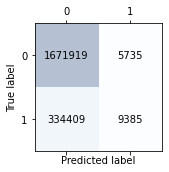

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [26]:
from xgboost import XGBClassifier

# 使用xgboost 建模，並指定先前調參得到的節點深度限制使用xgboost 建模，並指定先前調參得到的節點深度限制
model = XGBClassifier(tree_method = 'gpu_hist', n_jobs=-1, n_estimators=500, max_depth=11)
model.fit(X,y.values.ravel())
y_pred = model.predict(X)
print("Roc_auc_score: ",roc_auc_score(y,y_pred)*100,"%")

# 繪出混淆矩陣，查看預測結果
confmat = confusion_matrix(y_true=y, y_pred=y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

# 匯出submission並進行提交
submission = pd.read_csv(samplesubmision_file, compression='gzip', index_col='id')
submission[submission.columns[0]] = model.predict_proba(test)[:,1]
submission.to_csv('submission.csv')

本次提交分數為 .40560；Leader Board Top 1 分數為 0.37913

In [ ]:
from deepctr_torch.models import 